In [1]:
import os
import sys
import re
import pandas as pd
import time
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import keras
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
import operator
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [2]:
df=pd.read_csv("URL.csv")
cmoz=pd.read_csv('dmoz.csv')

In [3]:
df.head(4)

,1,http://www.liquidgeneration.com/,Adult
0,2,http://www.onlineanime.org/,Adult
1,3,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
2,4,http://www.galeon.com/kmh/,Adult
3,5,http://www.fanworkrecs.com/,Adult


In [4]:
cmoz.head(4)

,Unnamed: 0,category,title,desc
0,1,Arts,About.com: Animation Guide,Keep up with developments in online animation ...
1,2,Arts,Toonhound,"British cartoon, animation and comic strip cre..."
2,3,Arts,Enculturation: From Mouse to Mouse: Overcoming...,Essay by Patricia Pisters on the animated imag...
3,4,Arts,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...


In [5]:
cmoz["desc"]

0          Keep up with developments in online animation ...
1          British cartoon, animation and comic strip cre...
2          Essay by Patricia Pisters on the animated imag...
3          Michael Crandol takes an exhaustive look at th...
4          Chris Romano feels that the proliferation of F...
                                 ...                        
1195846    High school sports and athletes as well as spo...
1195847    High school sports scores, standings, and sche...
1195848    News, analysis, commentary, feature articles, ...
1195849                   Headline news and feature stories.
1195850    Features high school news and the Super 25 Ind...
Name: desc, Length: 1195851, dtype: object

In [6]:
cmoz.rename(columns = {'desc':'Description'}, inplace = True) 

In [7]:
cmoz.rename(columns = {'category':'Category','title':'Title'}, inplace = True) 

In [8]:
cmoz.isnull().sum()

Unnamed: 0     0
Category       0
Title          0
Description    0
dtype: int64

In [9]:
df.isnull().sum()

1                                   0
http://www.liquidgeneration.com/    3
Adult                               0
dtype: int64

In [10]:
cmoz.shape

(1195851, 4)

In [11]:
cmoz.rename(columns = {'Index':'Id'}, inplace = True) 

In [12]:
cmoz

,Unnamed: 0,Category,Title,Description
0,1,Arts,About.com: Animation Guide,Keep up with developments in online animation ...
1,2,Arts,Toonhound,"British cartoon, animation and comic strip cre..."
2,3,Arts,Enculturation: From Mouse to Mouse: Overcoming...,Essay by Patricia Pisters on the animated imag...
3,4,Arts,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...
4,5,Arts,Spark Online: Only Genius Is Genius,Chris Romano feels that the proliferation of F...
...,...,...,...,...
1195846,2196856,Sports,MaxPreps.com,High school sports and athletes as well as spo...
1195847,2196857,Sports,My Score,"High school sports scores, standings, and sche..."
1195848,2196858,Sports,Sports Illustrated: High School Sports,"News, analysis, commentary, feature articles, ..."
1195849,2196859,Sports,Sports Illustrated: High School Sports,Headline news and feature stories.


In [13]:
df.shape

(1562977, 3)

In [14]:
df.columns

Index(['1', 'http://www.liquidgeneration.com/', 'Adult'], dtype='object')

In [15]:
df.rename(columns = {'http://www.liquidgeneration.com/':'URL'}, inplace = True) 

In [16]:
df.drop(["1"], axis = 1, inplace = True)

In [17]:
df.head()

,URL,Adult
0,http://www.onlineanime.org/,Adult
1,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
2,http://www.galeon.com/kmh/,Adult
3,http://www.fanworkrecs.com/,Adult
4,http://www.animehouse.com/,Adult


In [18]:
vertical_concat = pd.concat([df, cmoz], axis=0)

In [22]:
# Id=cmoz['Id']

In [23]:
# Id

In [24]:
# df['Id']=Id

In [25]:
df.head()

,URL,Adult
0,http://www.onlineanime.org/,Adult
1,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult
2,http://www.galeon.com/kmh/,Adult
3,http://www.fanworkrecs.com/,Adult
4,http://www.animehouse.com/,Adult


In [26]:
display(df.dtypes)

URL      object
Adult    object
dtype: object

In [28]:
df1=df
cmoz1=cmoz

In [29]:
print(df1.shape)
print(cmoz1.shape)

(1562977, 2)
(1195851, 4)


In [30]:
df2=df1.join(cmoz1)

<AxesSubplot:>

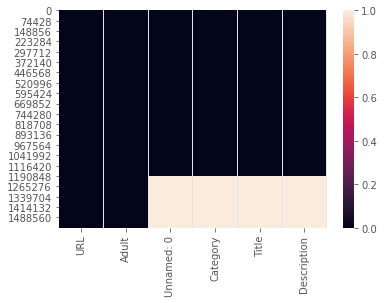

In [31]:
sns.heatmap(df2.isnull())

In [32]:
new_data = df2.dropna(axis = 0, how ='any')

<AxesSubplot:>

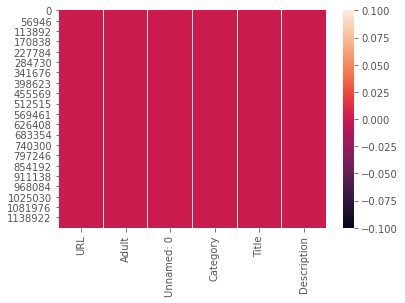

In [33]:
sns.heatmap(new_data.isnull())

In [34]:
new_data.dtypes

URL             object
Adult           object
Unnamed: 0     float64
Category        object
Title           object
Description     object
dtype: object

In [35]:
new_data['Adult'].unique()

array(['Adult', 'Arts', 'Business', 'Computers', 'Games', 'Health',
       'Home', 'Kids', 'News', 'Recreation', 'Reference', 'Science',
       'Shopping'], dtype=object)

In [36]:
new_data['Adult'].value_counts()

Arts          253840
Business      240176
Computers     117961
Science       110286
Recreation    106586
Shopping       73415
Health         60097
Reference      58247
Games          56477
Kids           46182
Adult          35324
Home           28269
News            8989
Name: Adult, dtype: int64

<AxesSubplot:>

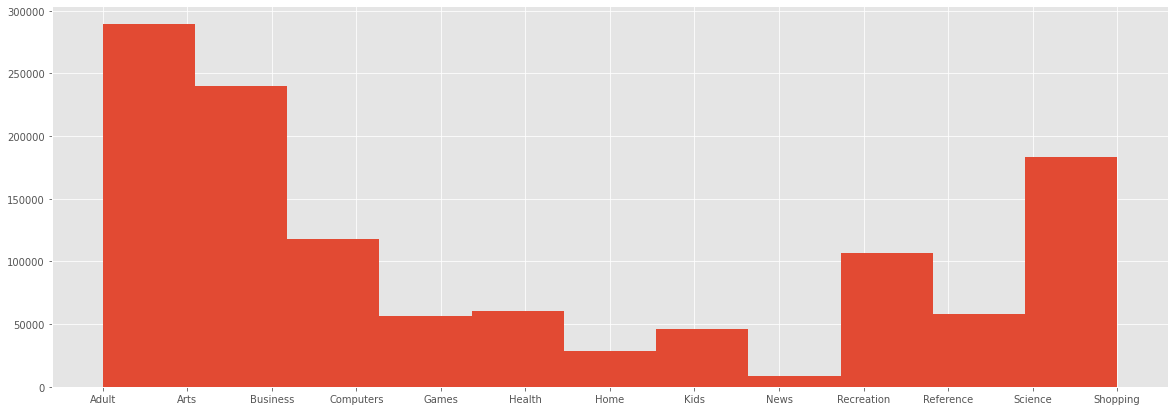

In [37]:
new_data['Adult'].hist(figsize=(20,7),bins=11)

In [38]:
new_data.head(6)

,URL,Adult,Unnamed: 0,Category,Title,Description
0,http://www.onlineanime.org/,Adult,1.0,Arts,About.com: Animation Guide,Keep up with developments in online animation ...
1,http://www.ceres.dti.ne.jp/~nekoi/senno/senfir...,Adult,2.0,Arts,Toonhound,"British cartoon, animation and comic strip cre..."
2,http://www.galeon.com/kmh/,Adult,3.0,Arts,Enculturation: From Mouse to Mouse: Overcoming...,Essay by Patricia Pisters on the animated imag...
3,http://www.fanworkrecs.com/,Adult,4.0,Arts,Digital Media FX: The History of Animation,Michael Crandol takes an exhaustive look at th...
4,http://www.animehouse.com/,Adult,5.0,Arts,Spark Online: Only Genius Is Genius,Chris Romano feels that the proliferation of F...
5,http://www2.117.ne.jp/~mb1996ax/enadc.html,Adult,6.0,Arts,Richard's Animated Divots,"Chronology of animated movies, television prog..."


Text(0, 0.5, 'Total Number Of Individual Category')

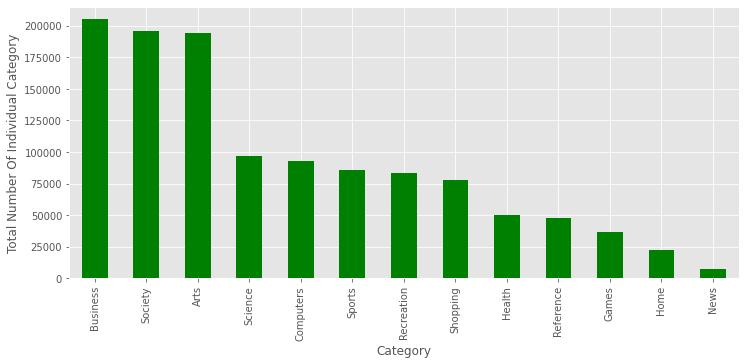

In [39]:
new_data.Category.value_counts().plot(figsize=(12,5),kind='bar',color='green')
plt.xlabel('Category')
plt.ylabel('Total Number Of Individual Category')

In [40]:
new_data.desc = new_data.Title + ' ' + new_data.Description
new_data = new_data.drop(['Title'], axis=1)
new_data.Description = new_data.Description.str.lower()

<ipython-input-40-3102d0031062>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  new_data.desc = new_data.Title + ' ' + new_data.Description


984 3 106.54380862466749


/home/jesterrexx/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Description length distribution')

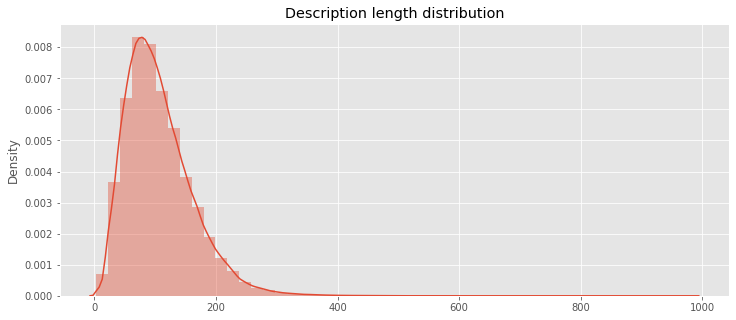

In [41]:
lens = [len(x) for x in new_data.Description]
plt.figure(figsize=(12, 5));
print (max(lens), min(lens), np.mean(lens))
sns.distplot(lens);
plt.title('Description length distribution')

In [42]:
import re
vocab_size = 5100
seq_len = 250
words = [re.findall('[\w\d]+', x) for x in new_data.Description]

In [43]:
all_words = []
for x in words:
    all_words += x

In [44]:
word_to_id = Counter(all_words).most_common(vocab_size)


In [45]:
word_to_id[:10]

[('and', 1479703),
 ('of', 600272),
 ('the', 521579),
 ('in', 344399),
 ('a', 284004),
 ('for', 263353),
 ('information', 218918),
 ('to', 217291),
 ('on', 148453),
 ('with', 128540)]

In [46]:
word_to_id[-10:]

[('applet', 343),
 ('vitamins', 343),
 ('unwanted', 343),
 ('creations', 342),
 ('wilmington', 342),
 ('displaying', 342),
 ('kevin', 342),
 ('might', 342),
 ('highland', 342),
 ('variations', 342)]

In [47]:
word_to_id = {x[0]:i for i, x in enumerate(word_to_id)}

In [48]:
train = [np.array([word_to_id[y] if y in word_to_id else vocab_size-1 for y in x]) for x in words]

In [49]:
train = sequence.pad_sequences(train, maxlen=seq_len, value=0)
train = train.astype('float32')

In [50]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(new_data.Category)
y_data = le.transform(new_data.Category)
X_data = new_data.Description.values

In [51]:
y_data = to_categorical(y_data)
X_train, X_test, y_train, y_test = train_test_split(train, y_data, test_size=0.3, random_state=1000)

In [52]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_len))
model.add(Dropout(0.1))
model.add(Conv1D(64,5,padding='valid',activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128,5,padding='valid',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 50)           255000    
_________________________________________________________________
dropout (Dropout)            (None, 250, 50)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 246, 64)           16064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 246, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 242, 128)          41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 242, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 121, 128)          0

In [53]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [54]:
model.optimizer.lr = 1e-3

In [55]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=2,batch_size=64)

Epoch 1/2
13080/13080 [==============================] - 1577s 121ms/step - loss: 1.0432 - accuracy: 0.6813 - val_loss: 0.8603 - val_accuracy: 0.7331
Epoch 2/2
13080/13080 [==============================] - 1567s 120ms/step - loss: 0.8758 - accuracy: 0.7290 - val_loss: 0.8129 - val_accuracy: 0.7441


In [56]:
from sklearn import metrics
preds = [np.argmax(x) for x in model.predict(X_test)]
y_test_argmax = [np.argmax(x) for x in y_test]
print(metrics.classification_report(preds, y_test_argmax, target_names=le.classes_))

              precision    recall  f1-score   support

        Arts       0.84      0.77      0.80     63870
    Business       0.82      0.78      0.80     65138
   Computers       0.76      0.72      0.74     29368
       Games       0.64      0.84      0.73      8272
      Health       0.73      0.74      0.73     15009
        Home       0.55      0.81      0.66      4557
        News       0.51      0.64      0.57      1748
  Recreation       0.68      0.68      0.68     24811
   Reference       0.52      0.58      0.55     12969
     Science       0.61      0.69      0.65     25677
    Shopping       0.64      0.77      0.70     19443
     Society       0.76      0.72      0.74     61912
      Sports       0.84      0.83      0.83     25981

    accuracy                           0.74    358755
   macro avg       0.69      0.74      0.71    358755
weighted avg       0.75      0.74      0.75    358755



<AxesSubplot:>

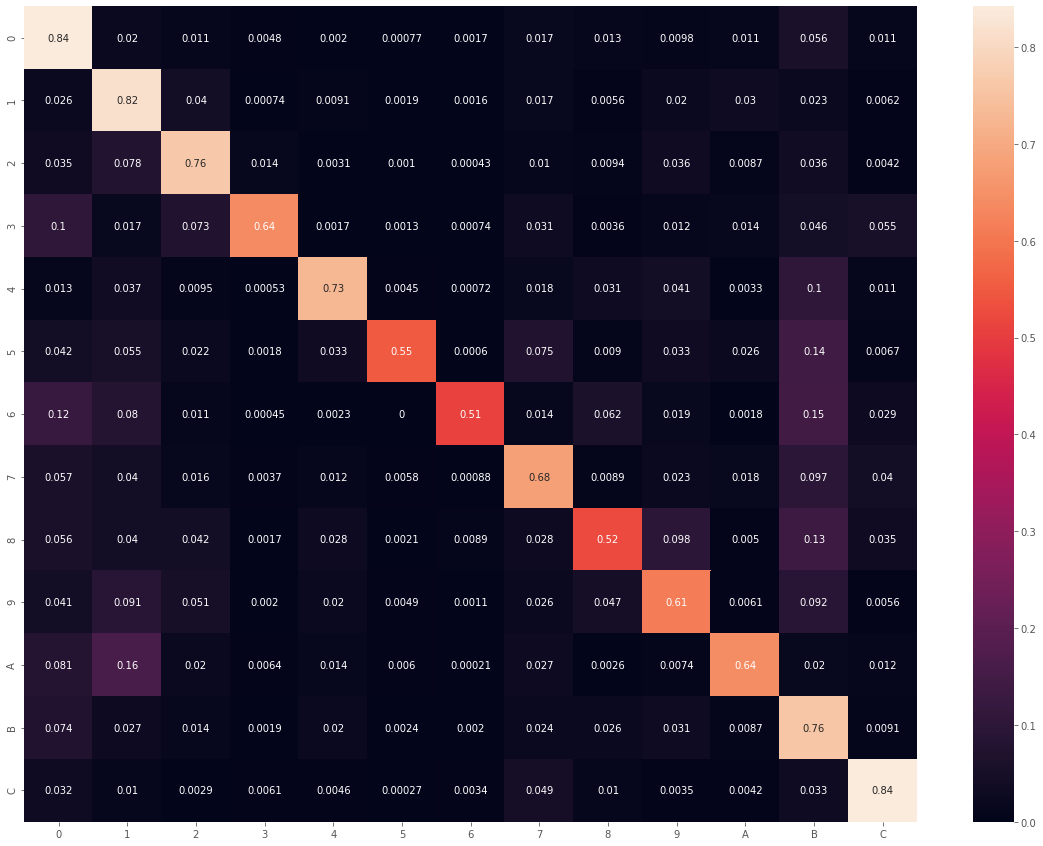

In [57]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
array = confusion_matrix(y_test_argmax, preds)
cm=np.array(array)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [i for i in "0123456789ABC"],
                  columns = [i for i in "0123456789ABC"])
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=True)

In [59]:
# model = Sequential()
# model.add(Embedding(max_words,50,input_length=max_len))
# model.add(LSTM(128,dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(4))
# model.add(Activation('softmax'))
# model.summary()